In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import tree
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, auc, precision_score, recall_score, precision_recall_curve

In [2]:
df = pd.read_csv('df_total_sp.csv')
df = df.drop(columns = ['SG_UF','NU_IDADE_N'])

In [3]:
df

,CRITERIO,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,CHIK
0,EpiClinico,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,Laboratorial,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
2,EpiClinico,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0
3,EpiClinico,1,1,1,0,0,0,1,0,1,1,0,0,0,1,0
4,Laboratorial,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1761395,Laboratorial,1,1,1,1,1,1,1,0,1,0,0,0,0,1,1
1761396,Laboratorial,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1
1761397,Laboratorial,1,1,1,0,1,1,0,0,0,0,0,0,0,0,1
1761398,Laboratorial,1,1,1,0,0,1,1,0,0,1,0,0,0,1,1


In [4]:
df_lab = df[df['CRITERIO'] == 'Laboratorial']
df_lab = df_lab.reset_index(drop = True)
df_epi = df[df['CRITERIO'] == 'EpiClinico'] 
df_epi = df_epi.reset_index(drop = True)
df_lab = df_lab.drop(columns = ['CRITERIO'])
df_epi = df_epi.drop(columns = ['CRITERIO'])

In [5]:
df_lab.shape

(857416, 15)

In [6]:
df_lab = df_lab.drop_duplicates()

In [7]:
df_lab.shape

(8436, 15)

### Train-test split

In [8]:
X = df_lab.iloc[:,0:13]
y = df_lab.iloc[:,14]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.6, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, test_size = 0.5, random_state = 0)

In [9]:
print('Train: ', y_train.shape, sum(y_train == 1), sum(y_train == 0))
print('Test: ', y_test.shape, sum(y_test == 1), sum(y_test == 0))
print('Validation: ', y_val.shape, sum(y_val == 1), sum(y_val == 0))

Train:  (3374,) 490 2884
Test:  (2531,) 368 2163
Validation:  (2531,) 368 2163


### Logistic regression

In [13]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)
y_pred_test = logreg.predict_proba(X_test)[:,1]
fpr_1, tpr_1, thresholds = roc_curve(y_test, y_pred_test, pos_label = 1)
print(roc_auc_score(y_test, y_pred_test))

0.8023050714587228


### Random Forest

In [14]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train ,y_train)
y_pred_test = rfc.predict_proba(X_test)[:,1]
fpr_2, tpr_2, thresholds = roc_curve(y_test, y_pred_test, pos_label = 1)
print(roc_auc_score(y_test, y_pred_test))

0.6460224074855777


### XGBoost

In [15]:
clx = XGBClassifier(random_state = 0, nthread = 8)
clx.fit(X_train, y_train)
y_pred_test = clx.predict_proba(X_test)[:,1]
fpr_3, tpr_3, thresholds = roc_curve(y_test, y_pred_test, pos_label = 1)
print(roc_auc_score(y_test, y_pred_test))

0.7313086695209954


### Random forest with class weights 

In [13]:
rfc = RandomForestClassifier(random_state = 0, class_weight = 'balanced')
rfc.fit(X_train ,y_train)
y_pred_train = rfc.predict_proba(X_train)[:,1]
fpr_4, tpr_4, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.9666559342183476


### Training with subsampling

In [14]:
num_train_chik = sum(y_train == 1)
ind_train_chik = (y_train == 1)

In [15]:
X_train_chik = X_train.loc[ind_train_chik]
y_train_chik = y_train.loc[ind_train_chik]
X_train_chik = X_train_chik.reset_index(drop = True)
y_train_chik = y_train_chik.reset_index(drop = True)

In [16]:
ind_train_denv = (y_train == 0)

In [17]:
X_train_denv = X_train.loc[ind_train_denv]
y_train_denv = y_train.loc[ind_train_denv]
X_train_denv = X_train_denv.reset_index(drop = True)
y_train_denv = y_train_denv.reset_index(drop = True)

In [18]:
indexes_denv = np.random.randint(0,X_train_denv.shape[0],num_train_chik)
X_train_denv = X_train_denv.loc[indexes_denv]
X_train_denv = X_train_denv.reset_index(drop = True)
y_train_denv = y_train_denv.loc[indexes_denv]
y_train_denv = y_train_denv.reset_index(drop = True)

In [19]:
X_train_2 = pd.concat([X_train_denv, X_train_chik])
y_train_2 = pd.concat([y_train_denv, y_train_chik])

In [20]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train_2, y_train_2)
y_pred_train = logreg.predict_proba(X_train_2)[:,1]
fpr_5, tpr_5, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.7912369845897542


In [21]:
rfc = RandomForestClassifier(random_state = 0)
rfc.fit(X_train_2 ,y_train_2)
y_pred_train = rfc.predict_proba(X_train_2)[:,1]
fpr_6, tpr_6, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.9949312786339025


In [22]:
clx = XGBClassifier(random_state = 0, nthread = 8)
clx.fit(X_train_2, y_train_2)
y_pred_train = clx.predict_proba(X_train_2)[:,1]
fpr_7, tpr_7, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.9917992503123699


### KNN classifier

In [23]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train, y_train)
y_pred_train = knn.predict_proba(X_train)[:,1]
fpr_8, tpr_8, thresholds = roc_curve(y_train, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train, y_pred_train))

0.8711087208808628


In [24]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train_2, y_train_2)
y_pred_train = knn.predict_proba(X_train_2)[:,1]
fpr_9, tpr_9, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

0.859073302790504


### Neural networks (1 layer)

In [25]:
model = Sequential()
model.add(Dense(100, input_dim = 13, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
history = model.fit(X_train_2, y_train_2, epochs = 200, verbose = 1)

Epoch 1/200
31/31 [==============================] - 1s 2ms/step - loss: 0.6704 - auc: 0.6494
Epoch 2/200
31/31 [==============================] - 0s 1ms/step - loss: 0.6332 - auc: 0.7573
Epoch 3/200
31/31 [==============================] - 0s 1ms/step - loss: 0.6066 - auc: 0.7800
Epoch 4/200
31/31 [==============================] - 0s 1ms/step - loss: 0.5860 - auc: 0.7874
Epoch 5/200
31/31 [==============================] - 0s 2ms/step - loss: 0.5713 - auc: 0.7922
Epoch 6/200
31/31 [==============================] - 0s 1ms/step - loss: 0.5621 - auc: 0.7937
Epoch 7/200
31/31 [==============================] - 0s 1ms/step - loss: 0.5557 - auc: 0.7962
Epoch 8/200
31/31 [==============================] - 0s 1ms/step - loss: 0.5514 - auc: 0.7981
Epoch 9/200
31/31 [==============================] - 0s 1ms/step - loss: 0.5481 - auc: 0.8002
Epoch 10/200
31/31 [==============================] - 0s 2ms/step - loss: 0.5456 - auc: 0.8015
Epoch 11/200
31/31 [==============================] - 0s 1m

31/31 [==============================] - 0s 2ms/step - loss: 0.3430 - auc: 0.9322
Epoch 173/200
31/31 [==============================] - 0s 2ms/step - loss: 0.3421 - auc: 0.9321
Epoch 174/200
31/31 [==============================] - 0s 2ms/step - loss: 0.3429 - auc: 0.9318
Epoch 175/200
31/31 [==============================] - 0s 1ms/step - loss: 0.3437 - auc: 0.9321
Epoch 176/200
31/31 [==============================] - 0s 1ms/step - loss: 0.3414 - auc: 0.9328
Epoch 177/200
31/31 [==============================] - 0s 1ms/step - loss: 0.3391 - auc: 0.9341
Epoch 178/200
31/31 [==============================] - 0s 2ms/step - loss: 0.3390 - auc: 0.9343
Epoch 179/200
31/31 [==============================] - 0s 1ms/step - loss: 0.3381 - auc: 0.9343
Epoch 180/200
31/31 [==============================] - 0s 2ms/step - loss: 0.3374 - auc: 0.9354
Epoch 181/200
31/31 [==============================] - 0s 2ms/step - loss: 0.3373 - auc: 0.9342
Epoch 182/200
31/31 [==============================] -

In [26]:
y_pred_train = model.predict(X_train_2).flatten()
fpr_10, tpr_10, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

31/31 [==============================] - 0s 1ms/step
0.9430924614743856


### Neural networks (2 layers)

In [27]:
model = Sequential()
model.add(Dense(100, input_dim = 13, activation='relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])
history = model.fit(X_train_2, y_train_2, epochs = 200, verbose = 1)

Epoch 1/200
31/31 [==============================] - 1s 1ms/step - loss: 0.6614 - auc: 0.6593
Epoch 2/200
31/31 [==============================] - 0s 1ms/step - loss: 0.5984 - auc: 0.7677
Epoch 3/200
31/31 [==============================] - 0s 1ms/step - loss: 0.5591 - auc: 0.7937
Epoch 4/200
31/31 [==============================] - 0s 2ms/step - loss: 0.5444 - auc: 0.8000
Epoch 5/200
31/31 [==============================] - 0s 2ms/step - loss: 0.5356 - auc: 0.8090
Epoch 6/200
31/31 [==============================] - 0s 2ms/step - loss: 0.5266 - auc: 0.8172
Epoch 7/200
31/31 [==============================] - 0s 2ms/step - loss: 0.5247 - auc: 0.8179
Epoch 8/200
31/31 [==============================] - 0s 2ms/step - loss: 0.5131 - auc: 0.8272
Epoch 9/200
31/31 [==============================] - 0s 1ms/step - loss: 0.5137 - auc: 0.8249
Epoch 10/200
31/31 [==============================] - 0s 2ms/step - loss: 0.4953 - auc: 0.8427
Epoch 11/200
31/31 [==============================] - 0s 2m

31/31 [==============================] - 0s 1ms/step - loss: 0.1054 - auc: 0.9937
Epoch 173/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1137 - auc: 0.9924
Epoch 174/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1118 - auc: 0.9930
Epoch 175/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1134 - auc: 0.9923
Epoch 176/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1125 - auc: 0.9924
Epoch 177/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1059 - auc: 0.9928
Epoch 178/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1072 - auc: 0.9930
Epoch 179/200
31/31 [==============================] - 0s 2ms/step - loss: 0.1033 - auc: 0.9930
Epoch 180/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1124 - auc: 0.9925
Epoch 181/200
31/31 [==============================] - 0s 1ms/step - loss: 0.1169 - auc: 0.9920
Epoch 182/200
31/31 [==============================] -

In [28]:
y_pred_train = model.predict(X_train_2).flatten()
fpr_11, tpr_11, thresholds = roc_curve(y_train_2, y_pred_train, pos_label = 1)
print(roc_auc_score(y_train_2, y_pred_train))

31/31 [==============================] - 0s 920us/step
0.9953915035401917


### Plotting all classifiers

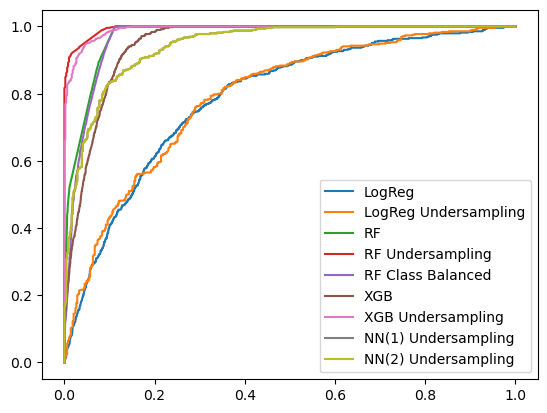

In [29]:
plt.plot(fpr_1, tpr_1, label = 'LogReg')
plt.plot(fpr_5, tpr_5, label = 'LogReg Undersampling')
plt.plot(fpr_2, tpr_2, label = 'RF')
plt.plot(fpr_6, tpr_6, label = 'RF Undersampling')
plt.plot(fpr_4, tpr_4, label = 'RF Class Balanced')
plt.plot(fpr_3, tpr_3, label = 'XGB')
plt.plot(fpr_7, tpr_7, label = 'XGB Undersampling')
#plt.plot(fpr_8, tpr_8, label = 'KNN')
#plt.plot(fpr_9, tpr_9, label = 'KNN Undersampling')
plt.plot(fpr_10, tpr_10, label = 'NN(1) Undersampling')
plt.plot(fpr_10, tpr_10, label = 'NN(2) Undersampling')
plt.legend()
plt.show()